<a href="https://colab.research.google.com/github/sattwiksuman/Digital_Operations_and_Supply_Chain_Management/blob/main/ABC_XYZ_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import random

In [ ]:
#Import data sets
df_demand_Q1 = pd.read_excel('/content/210224_01_Demand and delivery quantities Q1 2017.xlsx')
df_demand_Q2 = pd.read_excel('/content/210224_01_Demand and delivery quantities Q2 2017.xlsx')
df_demand_Q3 = pd.read_excel('/content/210224_01_Demand and delivery quantities Q3 2017.xlsx')
df_demand_Q4 = pd.read_excel('/content/210224_02_Demand and delivery quantities Q4 2017.xlsx')
frames = [df_demand_Q1, df_demand_Q2, df_demand_Q3, df_demand_Q4]
df_demand = pd.concat(frames, axis=0, join="outer", ignore_index=True)

In [ ]:
#Analyse the data
df_demand.info()
df_demand.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706799 entries, 0 to 706798
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Kunden-Nr.   706799 non-null  int64         
 1   Artikel-Nr.  706799 non-null  int64         
 2   Belegdatum   706799 non-null  datetime64[ns]
 3   Beleg-Nr.    706794 non-null  object        
 4   Menge        706799 non-null  float64       
 5   Stat.Menge   706799 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 32.4+ MB


,Kunden-Nr.,Artikel-Nr.,Menge,Stat.Menge
count,7.067990e+05,706799.000000,706799.000000,706799.000000
mean,1.111852e+09,14206.456138,62.397938,719.994373
std,2.677478e+08,5805.159665,150.690666,1714.722498
min,1.130220e+08,10002.000000,-185.000000,-2220.000000
25%,1.080001e+09,10272.000000,5.000000,60.000000
50%,1.080001e+09,10409.000000,15.000000,180.000000
75%,1.080003e+09,20330.000000,40.000000,480.000000
max,4.230009e+09,40197.000000,4872.000000,30720.000000


In [ ]:
df_123= df_demand.loc[df_demand['Artikel-Nr.']==10408][:].copy()

In [ ]:
df_123.head()

,Kunden-Nr.,Artikel-Nr.,Belegdatum,Beleg-Nr.,Menge,Stat.Menge
73079,1010002000,10408,2017-01-02,L117000109,160.0,1920.0
73080,1010002000,10408,2017-01-02,L117000188,800.0,9600.0
73081,1010002000,10408,2017-01-03,L117000583,960.0,11520.0
73082,1010002000,10408,2017-01-04,L117000602,40.0,480.0
73083,1010002000,10408,2017-01-05,L117001090,720.0,8640.0


In [ ]:
df_123_group = df_123.groupby([XYZ_on])

NameError: ignored

In [ ]:
#Define Function for ABC_XYZ analysis
def ABC_XYZ_Analysis(df, XYZ_on, according_to, date_column):
    items = df[XYZ_on].unique()   #list of all articles
    items_group = df.groupby([XYZ_on])
    df_items_grouped = df.groupby(XYZ_on)[according_to].sum().reset_index().copy()
    df_items_grouped['Sum']='NAN'
    df_items_grouped['Mean']='NAN'
    df_items_grouped['Std']='NAN'
    for item in items:
        dummy_df = items_group.get_group(item).copy()
        dummy_df.sort_values(by=date_column, ignore_index=True, inplace=True)
        dummy_df.index=dummy_df[date_column]
        weekly_val = dummy_df.groupby(pd.Grouper(freq='W'))[according_to].sum().reset_index()
        sum_sold = weekly_val[according_to].sum()
        mean_sold = weekly_val[according_to].mean()
        std_sold = weekly_val[according_to].std(ddof=0)
        df_items_grouped.loc[df_items_grouped[XYZ_on]==item, 'Sum']=sum_sold
        df_items_grouped.loc[df_items_grouped[XYZ_on]==item, 'Mean']=mean_sold
        df_items_grouped.loc[df_items_grouped[XYZ_on]==item, 'Std']=std_sold
    df_items_grouped['Variance_Coeff']=df_items_grouped['Std']/df_items_grouped['Mean']
    df_items_grouped.sort_values(by='Variance_Coeff', ascending=True, ignore_index=True, inplace=True)
    df_items_grouped['Class_XYZ']='Class Y'
    df_items_grouped.loc[df_items_grouped['Variance_Coeff']<=0.5, ['Class_XYZ']]='Class X'
    df_items_grouped.loc[df_items_grouped['Variance_Coeff']>1, ['Class_XYZ']]='Class Z'
    df_items_grouped['Percent_Sales'] = 100*df_items_grouped['Sum']/df_items_grouped['Sum'].sum()
    df_items_grouped.sort_values(by='Percent_Sales', ascending=False, ignore_index=True, inplace=True)
    df_items_grouped['Cumulative_Sales_Percentage'] = df_items_grouped['Percent_Sales'].cumsum()
    df_items_grouped['Class_ABC']='Class B'
    df_items_grouped.loc[df_items_grouped['Cumulative_Sales_Percentage']<=80, ['Class_ABC']]='Class A'
    df_items_grouped.loc[df_items_grouped['Cumulative_Sales_Percentage']>95, ['Class_ABC']]='Class C'
    df_items_grouped['Class_ABC_XYZ'] = 'TBD'
    df_items_grouped.loc[(df_items_grouped['Class_ABC']=='Class A') & (df_items_grouped['Class_XYZ']=='Class X'), ['Class_ABC_XYZ']]='A/X'
    df_items_grouped.loc[(df_items_grouped['Class_ABC']=='Class A') & (df_items_grouped['Class_XYZ']=='Class Y'), ['Class_ABC_XYZ']]='A/Y'
    df_items_grouped.loc[(df_items_grouped['Class_ABC']=='Class A') & (df_items_grouped['Class_XYZ']=='Class Z'), ['Class_ABC_XYZ']]='A/Z'
    df_items_grouped.loc[(df_items_grouped['Class_ABC']=='Class B') & (df_items_grouped['Class_XYZ']=='Class X'), ['Class_ABC_XYZ']]='B/X'
    df_items_grouped.loc[(df_items_grouped['Class_ABC']=='Class B') & (df_items_grouped['Class_XYZ']=='Class Y'), ['Class_ABC_XYZ']]='B/Y'
    df_items_grouped.loc[(df_items_grouped['Class_ABC']=='Class B') & (df_items_grouped['Class_XYZ']=='Class Z'), ['Class_ABC_XYZ']]='B/Z'
    df_items_grouped.loc[(df_items_grouped['Class_ABC']=='Class C') & (df_items_grouped['Class_XYZ']=='Class X'), ['Class_ABC_XYZ']]='C/X'
    df_items_grouped.loc[(df_items_grouped['Class_ABC']=='Class C') & (df_items_grouped['Class_XYZ']=='Class Y'), ['Class_ABC_XYZ']]='C/Y'
    df_items_grouped.loc[(df_items_grouped['Class_ABC']=='Class C') & (df_items_grouped['Class_XYZ']=='Class Z'), ['Class_ABC_XYZ']]='C/Z'
    return(df_items_grouped)

In [ ]:
#Invoke the function and save the output as a dataframe
df_articles_ABC_XYZ = ABC_XYZ_Analysis(df_demand, 'Artikel-Nr.', 'Stat.Menge', 'Belegdatum')

In [ ]:
#Check out the dataframe
df_articles_ABC_XYZ.head()

,Artikel-Nr.,Stat.Menge,Sum,Mean,Std,Variance_Coeff,Class_XYZ,Percent_Sales,Cumulative_Sales_Percentage,Class_ABC,Class_ABC_XYZ
0,10408,54666156.0,5.46662e+07,1.05127e+06,224011,0.213086,Class X,10.7422,10.7422,Class A,A/X
1,20410,49738548.0,4.97385e+07,956511,143935,0.150479,Class X,9.7739,20.5161,Class A,A/X
2,10101,35821248.0,3.58212e+07,688870,166256,0.241346,Class X,7.03908,27.5552,Class A,A/X
3,10407,31911372.0,3.19114e+07,613680,149174,0.243081,Class X,6.27076,33.826,Class A,A/X
4,20210,30988272.0,3.09883e+07,595928,88277.8,0.148135,Class X,6.08937,39.9153,Class A,A/X


In [ ]:
#Print the ABC_XYZ Table:
df_articles_ABC_XYZ['Class_ABC_XYZ'].value_counts()

C/Z    64
C/X    49
B/X    38
C/Y    37
A/X    24
B/Y     3
Name: Class_ABC_XYZ, dtype: int64

In [ ]:
#Save the dataframe as an excel file
df_articles_ABC_XYZ.to_excel('/content/Articles_ABC_XYZ_Analysis.xls')

In [ ]:
#Make list of articles in each class = 9 lists
articles_AX = df_articles_ABC_XYZ[df_articles_ABC_XYZ['Class_ABC_XYZ']=='A/X']['Artikel-Nr.'].tolist()
articles_AY = df_articles_ABC_XYZ[df_articles_ABC_XYZ['Class_ABC_XYZ']=='A/Y']['Artikel-Nr.'].tolist()
articles_AZ = df_articles_ABC_XYZ[df_articles_ABC_XYZ['Class_ABC_XYZ']=='A/Z']['Artikel-Nr.'].tolist()
articles_BX = df_articles_ABC_XYZ[df_articles_ABC_XYZ['Class_ABC_XYZ']=='B/X']['Artikel-Nr.'].tolist()
articles_BY = df_articles_ABC_XYZ[df_articles_ABC_XYZ['Class_ABC_XYZ']=='B/Y']['Artikel-Nr.'].tolist()
articles_BZ = df_articles_ABC_XYZ[df_articles_ABC_XYZ['Class_ABC_XYZ']=='B/Z']['Artikel-Nr.'].tolist()
articles_CX = df_articles_ABC_XYZ[df_articles_ABC_XYZ['Class_ABC_XYZ']=='C/X']['Artikel-Nr.'].tolist()
articles_CY = df_articles_ABC_XYZ[df_articles_ABC_XYZ['Class_ABC_XYZ']=='C/Y']['Artikel-Nr.'].tolist()
articles_CZ = df_articles_ABC_XYZ[df_articles_ABC_XYZ['Class_ABC_XYZ']=='C/Z']['Artikel-Nr.'].tolist()
max_articles = {'A/X': articles_AX, 'A/Y': articles_AY, 'A/Z': articles_AZ, 
                'B/X': articles_BX, 'B/Y': articles_BY, 'B/Z': articles_BZ,
                'C/X': articles_CX, 'C/Y': articles_CY, 'C/Z': articles_CZ}

In [ ]:
max_articles['A/X']

[10408,
 20410,
 10101,
 10407,
 20210,
 20230,
 10100,
 20430,
 20381,
 20440,
 10409,
 10102,
 10208,
 20387,
 10327,
 20380,
 20382,
 10401,
 10209,
 10207,
 10400,
 10427,
 10558,
 20386]

In [ ]:
#From each list select the article with max(Variance_Coeff)
max_vc = df_articles_ABC_XYZ.groupby('Class_ABC_XYZ')['Variance_Coeff'].max()

In [ ]:
df_articles_ABC_XYZ[df_articles_ABC_XYZ['Class_ABC_XYZ']=='C/Z']['Variance_Coeff'].max()

3.4820970692960307

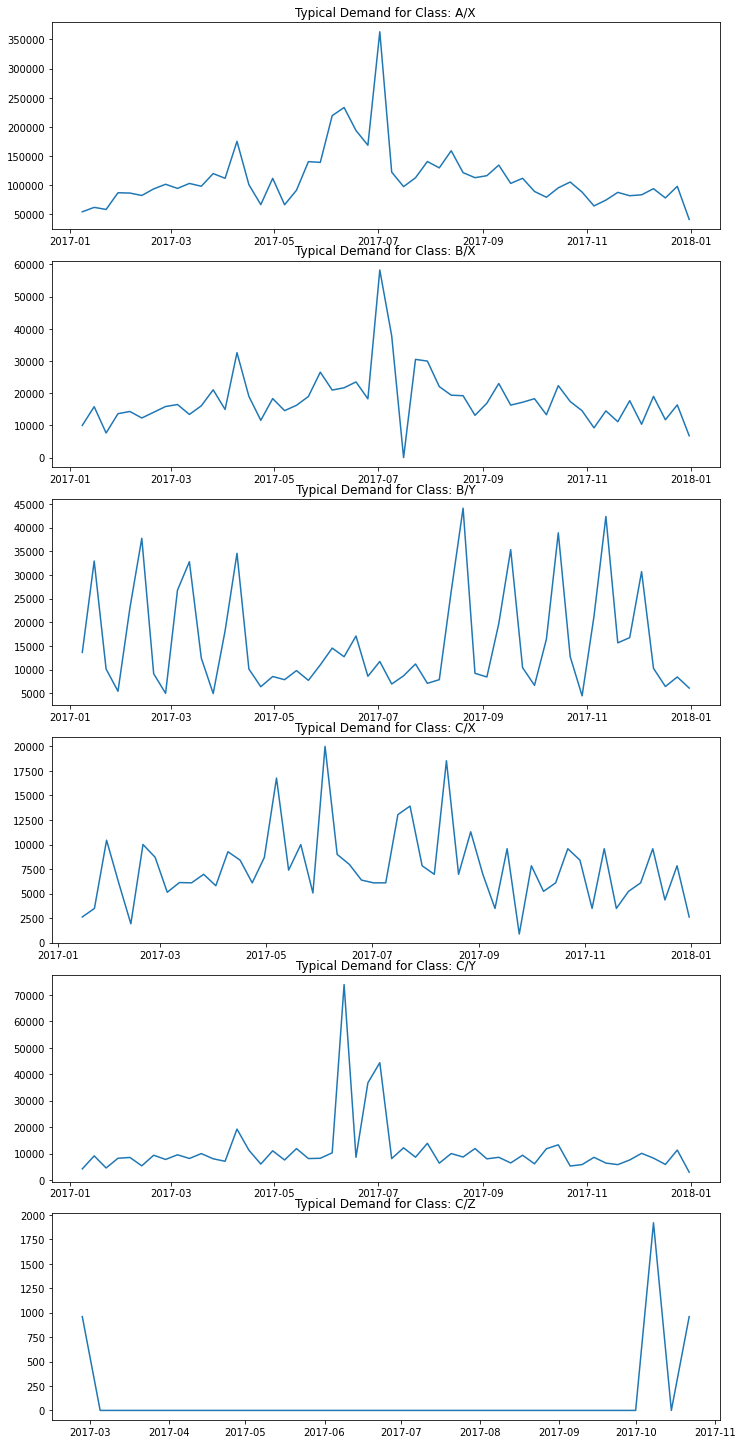

In [ ]:
#Plot one representative demand plot for article with max Variance Coeff. for each ABC_XYZ Class

fig, axs = plt.subplots(nrows=len(max_vc.index), ncols=1, figsize=(10, 20))
plt.rcParams.update({'font.size': 10})
fig.tight_layout()
for i, item in enumerate(max_vc.index):
    try:
        item_max_vc = df_articles_ABC_XYZ[(df_articles_ABC_XYZ['Artikel-Nr.'].isin(max_articles[item])) \
                                            & (df_articles_ABC_XYZ['Variance_Coeff']==max_vc[item])]['Artikel-Nr.']
        items_group = df_demand.groupby('Artikel-Nr.')
        dummy_df = items_group.get_group(item_max_vc.values[0]).copy()
        dummy_df.sort_values(by='Belegdatum', ignore_index=True, inplace=True)
        dummy_df.index=dummy_df['Belegdatum']
        weekly_val = dummy_df.groupby(pd.Grouper(freq='W'))['Stat.Menge'].sum().reset_index()
        axs[i].plot(weekly_val['Belegdatum'], weekly_val['Stat.Menge'])
        axs[i].set_title(f'Typical Demand for Class: {item}')
    except:
        try:
            item_max_vc = random.choice(max_articles[item])
            items_group = df_demand.groupby('Artikel-Nr.')
            dummy_df = items_group.get_group(item_max_vc.values[0]).copy()
            dummy_df.sort_values(by='Belegdatum', ignore_index=True, inplace=True)
            dummy_df.index=dummy_df['Belegdatum']
            weekly_val = dummy_df.groupby(pd.Grouper(freq='W'))['Stat.Menge'].sum().reset_index()
            axs[i].plot(weekly_val['Belegdatum'], weekly_val['Stat.Menge'])
            axs[i].set_title(f'Typical Demand for Class: {item}')
        except:
            pass
plt.savefig('/content/ABC_XYZ_Analysis.png')
plt.show()

###Plot as per Class and Metric Requirement


In [ ]:
#Choose a class to select an article:
#choose between 'A/X', 'B/X', 'B/Y', 'C/X', 'C/Y', 'C/Z' as these are the only classes with products
item = 'C/X'

In [ ]:
#choose a metric so select the article from the class selected above
#chose between 'max', 'min', 'random'

metric = 'random'
if metric in ['max', 'min', 'median']:
    metric_vc = df_articles_ABC_XYZ.groupby('Class_ABC_XYZ').agg({'Variance_Coeff': metric})
    item_metric_vc = df_articles_ABC_XYZ[(df_articles_ABC_XYZ['Artikel-Nr.'].isin(max_articles[item])) \
                                            & (df_articles_ABC_XYZ['Variance_Coeff']==metric_vc.loc[item]['Variance_Coeff'])]['Artikel-Nr.']
else:
    item_metric_vc = random.choice(max_articles[item])

In [ ]:
#Run the cell if you want to ensure the article number that has been selected by the above cell
item_metric_vc

13073

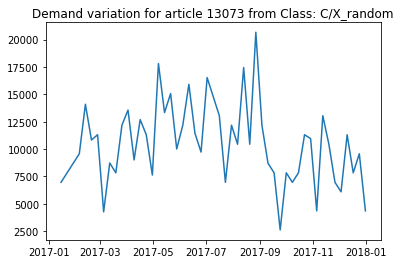

In [ ]:
items_group = df_demand.groupby('Artikel-Nr.')
if metric=='random':
    dummy_df = items_group.get_group(item_metric_vc).copy()
else:
    dummy_df = items_group.get_group(item_metric_vc.values[0]).copy()
dummy_df.sort_values(by='Belegdatum', ignore_index=True, inplace=True)
dummy_df.index=dummy_df['Belegdatum']
weekly_val = dummy_df.groupby(pd.Grouper(freq='W'))['Stat.Menge'].sum().reset_index()
plt.plot(weekly_val['Belegdatum'], weekly_val['Stat.Menge'])
if metric=='random':
    plt.title(f'Demand variation for article {item_metric_vc} from Class: {item}_{metric}')
    plot_name=f'Class_{item}_article_{item_metric_vc}_{metric}'
else:
    plt.title(f'Demand variation for article {item_metric_vc.values[0]} from Class: {item}_{metric}')
    plot_name=f'Class_{item}_article_{item_metric_vc.values[0]}_{metric}'
plt.savefig('/content/'+plot_name.replace('/', '_')+'.png')